In [1]:
# Necessary installation for dimensionality Multicollinearity
! pip install varclushi

In [19]:
import pickle
import json
import matplotlib.pyplot as plt
import datetime 
import numpy as np
import pandas as pd
from functools import reduce
from varclushi import VarClusHi
from google.cloud import aiplatform, bigquery, storage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.losses import BinaryCrossentropy 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

## Get data from Big Query

In [3]:
client = bigquery.Client()
query_job = client.query(
"""
SELECT
    id
    ,symbol
    ,name
    ,date
    ,market_data.current_price as current_price
    ,market_data.market_cap as market_cap
    ,market_data.total_volume as total_volume  
FROM
    `crispy-computing-machine.crispy_dwh.crypto_btc`
""")
df = query_job.result().to_dataframe()

* Create a column for time ordered by day.
* t0 is a hyperparameter for the initial day for trainning

In [4]:
t0 = datetime.datetime(2021, 1, 1)

df["date"]=pd.to_datetime(df["date"])
df=df[df["date"]>=t0]
df.sort_values(by=["date"],ascending=True,inplace=True)
df.reset_index(drop=True,inplace=True)
df.reset_index(drop=False,inplace=True)
df.rename(columns={"index":"t"},inplace=True)

* Summary of our dataframe

In [5]:
completitud=pd.DataFrame((1-df.isnull().sum()/df.shape[0])*100).reset_index().rename(columns={"index":"columna",0:"completitud"})
missings=pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={"index":"columna",0:"missings"})
completitud=completitud.merge(missings,how="inner",on="columna")
tipo=pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"columna",0:"type"})
completitud=completitud.merge(tipo,how="inner",on="columna")
completitud

,columna,completitud,missings,type
0,t,100.0,0,int64
1,id,100.0,0,object
2,symbol,100.0,0,object
3,name,100.0,0,object
4,date,100.0,0,datetime64[ns]
5,current_price,100.0,0,float64
6,market_cap,100.0,0,float64
7,total_volume,100.0,0,float64


## Feature Engineering 

In [6]:
%%writefile feature_engineering.py

import numpy as np
import pandas as pd
from functools import reduce

class window_time(object):
    """
    Class for feature engineering. Get a time window from the features current_price,
    market_cap, total_volume and get a time window from future incremental current_price.    

    Attributes
    ----------
    vobs : int
        Observation window backward for each day
    vdes : int
        Performance window forward for each day
    step : int
        Number of days grouped to get metrics in the observation window
    incremental : int
        Porcentage of increment minimum of the price in the performance window
    anclai: int
        Minimum day in data such that its observation window is full defined
    anclaf: int
        Maximum day in data such that its performance window is full defined
        
    Methods
    -------
    anclas(time_column)
        Initializes anclai and anclaf
    ing_X(df,ancla,k)
        Gets current_price mean, current_price std, market_cap mean, market_cap std,
        total_volume mean, total_volume std from a specific day and a specific 
        observation window
    ing_Y(df,ancla,inc)
        Gets a binary feature from a specific day and the perfomance window (vdes).
        1 when the future performance window price is greater than or equal to 
        the current price plus and specific incremental rate (inc); 0 in any other case
    eng_X(df,um)
        Gets all observation window features for each day in the data frame
    eng_Y(df)
        Gets all performance window features for each day in the data frame
    """
    def __init__(self,vobs,vdes,step,incremental):
        """
        Parameters
        ----------
        vobs : int
            Observation window backward for each day
        vdes : int
            Performance window forward for each day
        step : int
            Number of days grouped to get metrics in the observation window
        incremental : float
            Porcentage of increment minimum of the price in the performance window
        """
        self.vobs = vobs
        self.vdes = vdes    
        self.step = step
        self.incremental = incremental
    
    def anclas(self, time_column):
        """
        Initializes anclai and anclaf
        
        Parameters
        ----------        
        time_column : pd.Series
            Field of data frame to consider as day feature
        """
        self.anclai = self.vobs-1
        self.anclaf = time_column.max()- self.vdes
        
    def ing_X(self,df,ancla,k):
        """
        Gets current_price mean, current_price std, market_cap mean, market_cap std,
        total_volume mean, total_volume std from a specific day and a specific 
        observation window
        
        Parameters
        ----------        
        df : pd.DataFrame
            Data frame. The day feature must be named 't'
        ancla : int
            Initial day to get the features for observation window
        k: int
            Size (in days) for observation window
        
        Returns
        -------
        pd.DataFrame
            Data frame with the features from the observation window time of initial day (ancla)
        """
        
        l = []
        
        aux = df.loc[(df['t'] <= ancla) & (df['t'] >= (ancla-k+1))]
        
        #current_price_mean
        piv = aux.pivot_table(index='symbol',columns='t',values='current_price',aggfunc='sum')
        piv[f'x_current_price_mean_{k}'] = piv.mean(axis=1)
        l.append(piv.filter(like='x_'))
        
        #current_price_std
        piv = aux.pivot_table(index='symbol',columns='t',values='current_price',aggfunc='sum')
        piv[f'x_current_price_std_{k}'] = piv.std(axis=1)
        l.append(piv.filter(like='x_'))   
        
        #market_cap_mean
        piv = aux.pivot_table(index='symbol',columns='t',values='market_cap',aggfunc='sum')
        piv[f'x_market_cap_mean_{k}'] = piv.mean(axis=1)
        l.append(piv.filter(like='x_'))

        #market_cap_std
        piv = aux.pivot_table(index='symbol',columns='t',values='market_cap',aggfunc='sum')
        piv[f'x_market_cap_std_{k}'] = piv.std(axis=1)
        l.append(piv.filter(like='x_'))   

        #total_volume_mean
        piv = aux.pivot_table(index='symbol',columns='t',values='total_volume',aggfunc='sum')
        piv[f'x_total_volume_mean_{k}'] = piv.mean(axis=1)
        l.append(piv.filter(like='x_'))

        #total_volume_std
        piv = aux.pivot_table(index='symbol',columns='t',values='total_volume',aggfunc='sum')
        piv[f'x_total_volume_std_{k}'] = piv.std(axis=1)
        l.append(piv.filter(like='x_'))   

        aux = reduce(lambda x,y:pd.merge(x,y,left_index=True,right_index=True,how='outer'),l).reset_index()
        aux.insert(1,'ancla',ancla)
    
        return aux
    
    def ing_Y(self,df,ancla,inc):
        """
        Gets a binary feature from a specific day and the perfomance window (vdes).
        1 when the future performance window price is greater than or equal to 
        the current price plus and specific incremental rate (inc); 0 in any other case
        
        Parameters
        ----------        
        df : pd.DataFrame
            Data frame. The day feature must be named 't'
        ancla : int
            Initial day to get the features for performance window
        inc: float
            Incremental rate target for the initial day
        
        Returns
        -------
        pd.DataFrame
            Data frame with the features from the performance window time of initial day (ancla)
        """
        
        valor=df.loc[(df['t']>ancla-1)&(df['t']<=(ancla))][['current_price']].values[0][0]
        aux=df.loc[(df['t']>ancla)&(df['t']<=(ancla+self.vdes))][['symbol','current_price']]
        aux['tgt']=valor
        aux['ptgt']=aux["current_price"]/aux["tgt"]-1
        aux['obj']=np.where(aux['ptgt']>=inc,1,0)
        aux=aux['obj'].values
        aux=[i for i in range(len(aux)) if aux[i] ==1]
        if len(aux)>0:
            aux=1
        else:
            aux=0
        aux2 = df.loc[(df['t']>ancla)&(df['t']<=(ancla+self.vdes))][['symbol']].drop_duplicates().reset_index(drop=True).assign(tgt=aux)
        aux2.insert(1,'ancla',ancla)
        
        return aux2
    
    def eng_X(self,df,um):
        """
        Gets all observation window features for each day in the data frame
        
        Parameters
        ----------        
        df : pd.DataFrame
            Data frame to get all the features
        um : list
            List of data frame headers such that they define the sample unit
        
        Returns
        -------
        pd.DataFrame
            Data frame with all the features from the observation window time of all days
        """
        
        cruzar = lambda x,y:pd.merge(x,y,on=um,how='outer')
        
        apilar = lambda x,y:x.append(y,ignore_index=True)
        
        X = reduce(apilar,
                    map(lambda ancla:
                        reduce(cruzar,
                                map(lambda k:self.ing_X(df,ancla,k),range(self.step,self.vobs+self.step,self.step))
                                ),
                    range(self.anclai,self.anclaf+1)
                        )
                    )
        return X
    
    def eng_Y(self,df):
        """
        Gets all performance window features for each day in the data frame
        
        Parameters
        ----------        
        df : pd.DataFrame
            Data frame to get all the performance binary feature
        
        Returns
        -------
        pd.DataFrame
            Data frame with all the features from the performance window time of all days
        """
        
        apilar = lambda x,y:x.append(y,ignore_index=True)
        
        Y = reduce(apilar,map(lambda ancla:self.ing_Y(df,ancla,self.incremental),range(self.anclai,self.anclaf+1)))
        
        return Y

Overwriting feature_engineering.py


* Save in project bucket

In [7]:
!gsutil cp feature_engineering.py gs://crispy-bucket-2022/models/utils/feature_engineering.py
!gsutil cp gs://crispy-bucket-2022/models/utils/feature_engineering.py feature_engineering.py

Copying file://feature_engineering.py [Content-Type=text/x-python]...
/ [1 files][  7.8 KiB/  7.8 KiB]                                                
Operation completed over 1 objects/7.8 KiB.                                      
Copying gs://crispy-bucket-2022/models/utils/feature_engineering.py...
/ [1 files][  7.8 KiB/  7.8 KiB]                                                
Operation completed over 1 objects/7.8 KiB.                                      


* Execute window_time class

In [8]:
from feature_engineering import window_time

window=window_time(vobs=60,vdes=7,step=15,incremental=0.1)
window.anclas(df['t'])
X=window.eng_X(df,['symbol','ancla'])
Y=window.eng_Y(df)

* Save X, Y dataframes... because it takes a lot of time

In [9]:
with open('X_v1.pkl', 'wb') as f:
    pickle.dump(X,f)
    
with open('Y_v1.pkl', 'wb') as f:
    pickle.dump(Y,f)

* See Y's distribution

In [10]:
Y["tgt"].value_counts(1)

0    0.799031
1    0.200969
Name: tgt, dtype: float64

## Features selection

* Load X, Y dataframes

In [11]:
with open('X_v1.pkl', 'rb') as f:
    X = pickle.load(f)

with open('Y_v1.pkl', 'rb') as f:
    Y = pickle.load(f)

* Define some important variables

In [12]:
um=['symbol','ancla']

tad = X.merge(Y,on=um,how='left')
varc = sorted(tad.filter(like='x_').columns)
vart = ['tgt']

* Summary of our dataframe

In [13]:
completitud=pd.DataFrame((1-tad.isnull().sum()/tad.shape[0])*100).reset_index().rename(columns={"index":"columna",0:"completitud"})
missings=pd.DataFrame(tad.isnull().sum()).reset_index().rename(columns={"index":"columna",0:"missings"})
completitud=completitud.merge(missings,how="inner",on="columna")
tipo=pd.DataFrame(tad.dtypes).reset_index().rename(columns={"index":"columna",0:"type"})
completitud=completitud.merge(tipo,how="inner",on="columna")
completitud

,columna,completitud,missings,type
0,symbol,100.0,0,object
1,ancla,100.0,0,int64
2,x_current_price_mean_15,100.0,0,float64
3,x_current_price_std_15,100.0,0,float64
4,x_market_cap_mean_15,100.0,0,float64
5,x_market_cap_std_15,100.0,0,float64
6,x_total_volume_mean_15,100.0,0,float64
7,x_total_volume_std_15,100.0,0,float64
8,x_current_price_mean_30,100.0,0,float64
9,x_current_price_std_30,100.0,0,float64


### Outliers

* Features distributions with outliers

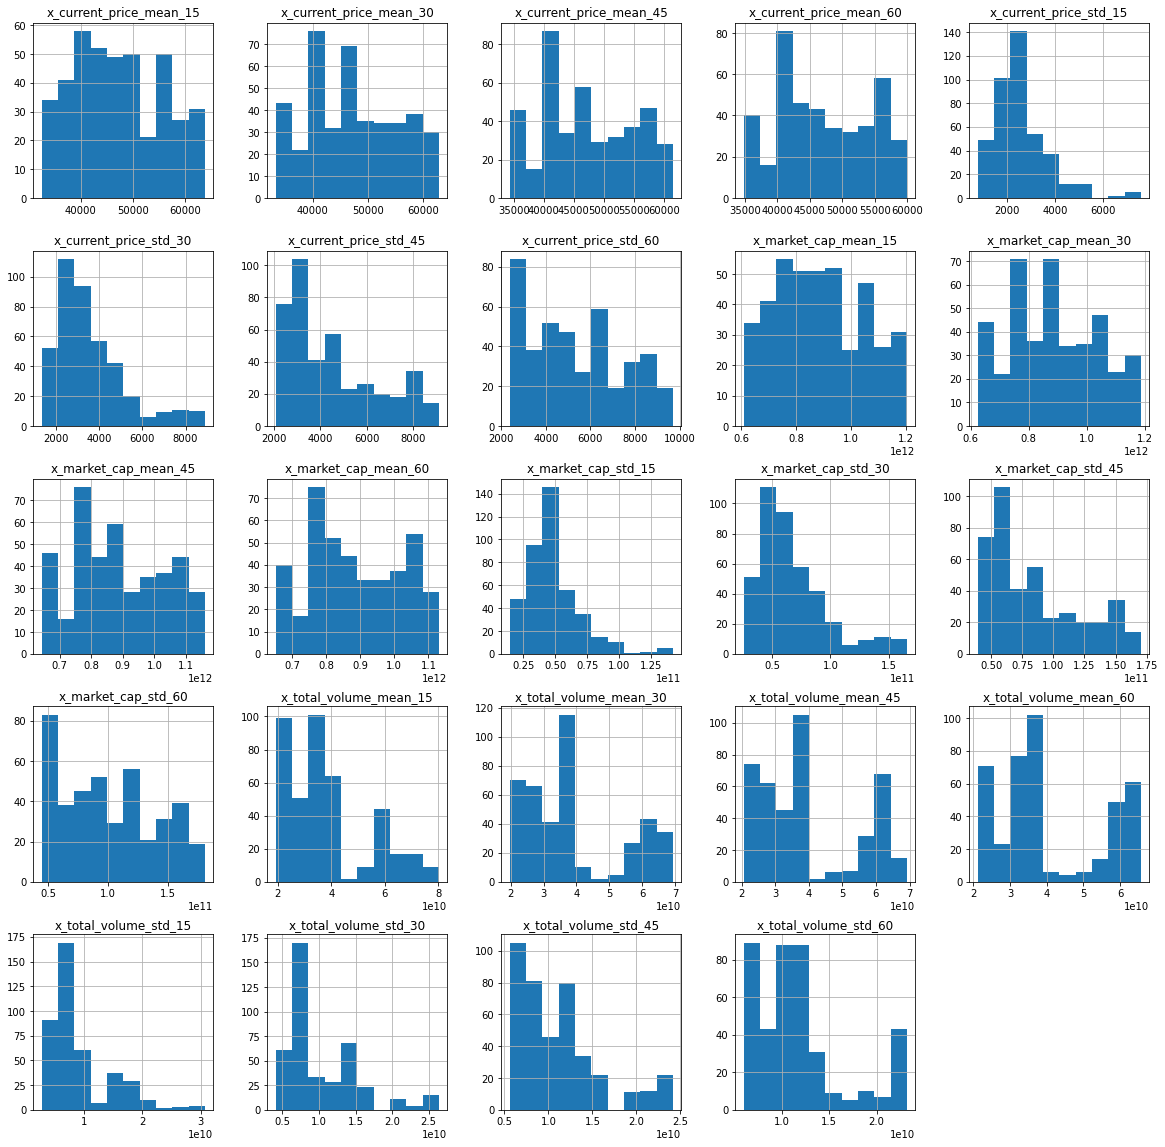

In [14]:
X[varc].hist(figsize=(20,20));

* Delete outliers

In [15]:
for v,li,ls in X[varc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X[f'ex_{v}'] = ((X[v]<li)|(X[v]>ls)).astype(int)
    
X['ex_'] = X.filter(like= 'ex_').max(axis=1)
X = X.loc[X['ex_']==0].reset_index(drop=True)
X.drop(X.filter(like='ex_').columns,axis=1,inplace=True)

* Features distributions without outliers

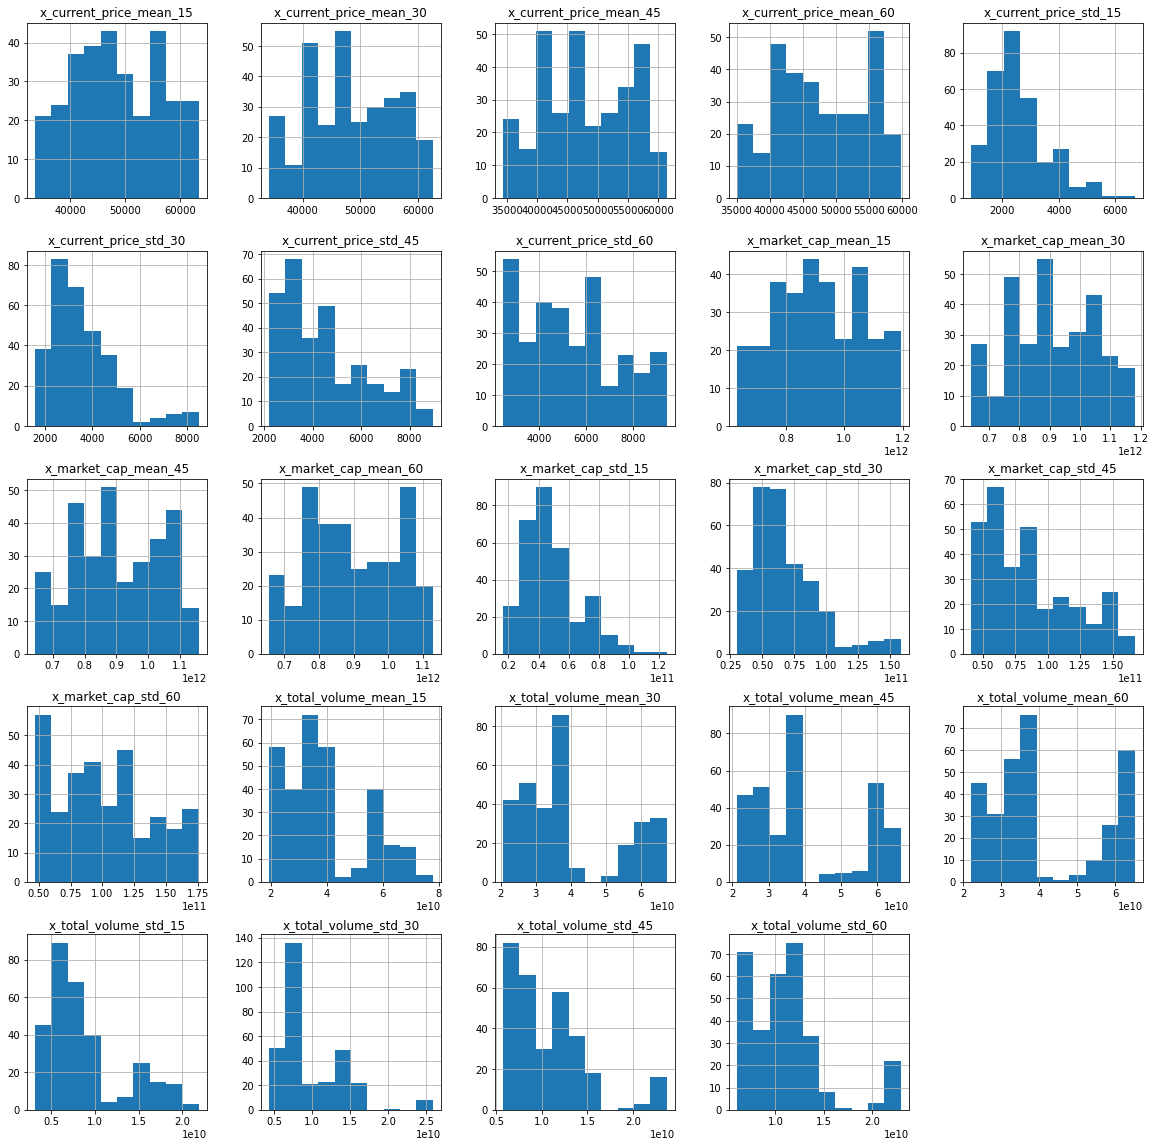

In [16]:
X[varc].hist(figsize=(20,20));

### Multicollinearity

* Correlation of all features

In [17]:
X[varc].corr()

t,x_current_price_mean_15,x_current_price_mean_30,x_current_price_mean_45,x_current_price_mean_60,x_current_price_std_15,x_current_price_std_30,x_current_price_std_45,x_current_price_std_60,x_market_cap_mean_15,x_market_cap_mean_30,...,x_market_cap_std_45,x_market_cap_std_60,x_total_volume_mean_15,x_total_volume_mean_30,x_total_volume_mean_45,x_total_volume_mean_60,x_total_volume_std_15,x_total_volume_std_30,x_total_volume_std_45,x_total_volume_std_60
t,,,,,,,,,,,,,,,,,,,,,
x_current_price_mean_15,1.000000,0.947929,0.836940,0.686866,0.187312,0.255192,0.300740,0.228503,0.999454,0.945458,...,0.303670,0.235103,0.581970,0.531234,0.471861,0.414400,0.245140,0.071792,-0.130301,-0.201193
x_current_price_mean_30,0.947929,1.000000,0.951310,0.841245,0.151342,0.162863,0.245306,0.209930,0.948191,0.999392,...,0.245597,0.214390,0.570821,0.554590,0.503753,0.451344,0.353584,0.189549,-0.021796,-0.109373
x_current_price_mean_45,0.836940,0.951310,1.000000,0.957343,0.151847,0.132255,0.166409,0.159034,0.839393,0.953724,...,0.164749,0.161076,0.489125,0.499063,0.475408,0.432669,0.370694,0.270687,0.076728,-0.024158
x_current_price_mean_60,0.686866,0.841245,0.957343,1.000000,0.120233,0.120412,0.139057,0.132990,0.691859,0.846958,...,0.136065,0.132928,0.367058,0.395784,0.400396,0.380025,0.369759,0.290361,0.171029,0.075436
x_current_price_std_15,0.187312,0.151342,0.151847,0.120233,1.000000,0.356549,0.015980,-0.084656,0.180573,0.143464,...,0.011240,-0.088253,0.386815,0.293702,0.296403,0.263865,0.280392,0.202094,0.158082,-0.022563
x_current_price_std_30,0.255192,0.162863,0.132255,0.120412,0.356549,1.000000,0.572694,0.202138,0.254047,0.160303,...,0.572448,0.202228,0.221736,0.220441,0.169772,0.152233,0.046756,0.193608,0.090632,-0.049505
x_current_price_std_45,0.300740,0.245306,0.166409,0.139057,0.015980,0.572694,1.000000,0.704885,0.297593,0.241688,...,0.999868,0.706338,0.212346,0.295486,0.264927,0.241321,0.019159,0.270905,0.281631,0.181737
x_current_price_std_60,0.228503,0.209930,0.159034,0.132990,-0.084656,0.202138,0.704885,1.000000,0.220810,0.201609,...,0.703658,0.999884,0.262144,0.347384,0.402883,0.396361,0.111915,0.285199,0.520647,0.514135
x_market_cap_mean_15,0.999454,0.948191,0.839393,0.691859,0.180573,0.254047,0.297593,0.220810,1.000000,0.946863,...,0.300827,0.227684,0.557339,0.505896,0.445990,0.387762,0.237822,0.058966,-0.146823,-0.220044


* Identify features clusters and select the best for each cluster such that there is not multicollinearity

In [18]:
vc = VarClusHi(df=X,feat_list=varc)
vc.varclus()
rs = vc.rsquare
rs = rs.sort_values(by=['Cluster','RS_Ratio']).reset_index(drop=True)
rs['id'] = rs.groupby('Cluster').cumcount()+1
best = rs.loc[rs['id']==1]['Variable'].tolist()
best

['x_current_price_mean_45',
 'x_total_volume_mean_45',
 'x_market_cap_std_60',
 'x_current_price_std_15',
 'x_current_price_std_30',
 'x_total_volume_std_45']

* Save best features

In [21]:
with open('best_v1.pkl', 'wb') as f:
    pickle.dump(best,f)

* Load best features

In [22]:
with open('best_v1.pkl', 'rb') as f:
    best = pickle.load(f)

* Best features distributions

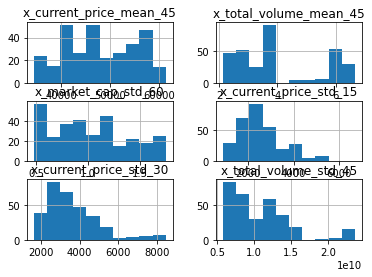

In [24]:
X[best].hist();

* Correlation of best features

In [25]:
X[best].corr()

t,x_current_price_mean_45,x_total_volume_mean_45,x_market_cap_std_60,x_current_price_std_15,x_current_price_std_30,x_total_volume_std_45
t,,,,,,
x_current_price_mean_45,1.000000,0.475408,0.161076,0.151847,0.132255,0.076728
x_total_volume_mean_45,0.475408,1.000000,0.396479,0.296403,0.169772,0.606607
x_market_cap_std_60,0.161076,0.396479,1.000000,-0.088253,0.202228,0.510815
x_current_price_std_15,0.151847,0.296403,-0.088253,1.000000,0.356549,0.158082
x_current_price_std_30,0.132255,0.169772,0.202228,0.356549,1.000000,0.090632
x_total_volume_std_45,0.076728,0.606607,0.510815,0.158082,0.090632,1.000000


## Scaler and Split

* Define some important variables

In [26]:
um=['symbol','ancla']

tad = X[um+best].merge(Y,on=um,how='left')
varc = sorted(tad.filter(like='x_').columns)
vart = ['tgt']

* Summary of our dataframe

In [27]:
completitud=pd.DataFrame((1-tad.isnull().sum()/tad.shape[0])*100).reset_index().rename(columns={"index":"columna",0:"completitud"})
missings=pd.DataFrame(tad.isnull().sum()).reset_index().rename(columns={"index":"columna",0:"missings"})
completitud=completitud.merge(missings,how="inner",on="columna")
tipo=pd.DataFrame(tad.dtypes).reset_index().rename(columns={"index":"columna",0:"type"})
completitud=completitud.merge(tipo,how="inner",on="columna")
completitud

,columna,completitud,missings,type
0,symbol,100.0,0,object
1,ancla,100.0,0,int64
2,x_current_price_mean_45,100.0,0,float64
3,x_total_volume_mean_45,100.0,0,float64
4,x_market_cap_std_60,100.0,0,float64
5,x_current_price_std_15,100.0,0,float64
6,x_current_price_std_30,100.0,0,float64
7,x_total_volume_std_45,100.0,0,float64
8,tgt,100.0,0,int64


In [28]:
%%writefile transform.py

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

class scaler_split(object):
    """
    Class for scaling and splitting independent and target features.    

    Attributes
    ----------
    df : pd.DataFrame
        Data frame to get the independent and target features
    X : list
        List of data frame independent headers 
    Y : list
        List of data frame target header
    X_train : array
        Train set of independient features
    X_val : array
        Validation set of independient features
    X_test: array
        Test set of independient features
    Y_train : pd.DataFrame
        Train set of target feature
    Y_val : pd.DataFrame
        Validation set of target feature
    Y_test: pd.DataFrame
        Test set of target feature
    Methods
    -------
    split(val,test,rs=None)
        Splits data frame and gets train, validation, test sets
    scaler(scaler='MinMaxScaler')
        Scales independient (X) sets. There are tow options MinMaxScaler and StandardScaler
    """
    
    def __init__(self, df,X,Y):
        """
        Parameters
        ----------
        df : pd.DataFrame
            Data frame to get the independent and target features
        X : list
            List of data frame independent headers 
        Y : list
            List of data frame target header
        """
        self.df = df
        self.X = X
        self.Y = Y
        
    def split(self,val,test,rs=None):
        """
        Gets X_train, X_val, X_test, Y_train, Y_val, Y_test
        
        Parameters
        ----------        
        val : float
            Must be between 0 and 1. Porcentage of validation set
        test : float
            Must be between 0 and 1. Porcentage of test set
        rs : float
            Random state for split. Default = None
        """
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.df[self.X],self.df[self.Y], test_size=test,random_state=rs)
        self.X_train, self.X_val, self.Y_train, self.Y_val = train_test_split(self.X_train,self.Y_train, test_size=val/(1-test),random_state=rs)
    
    def scaler(self, scaler='MinMaxScaler'):
        """
        Scales X_train, X_val, X_test
        
        Parameters
        ----------        
        scaler : string
            'MinMaxScaler': Uses MinMaxScaler from scikit-learn
            'StandardScaler': Uses StandardScaler from scikit-learn
            In another case, it does not scale
        
        Returns
        -------
        object
            Returns object scaler. If scaler not in ('MinMaxScaler','StandardScaler'),
            returns None
        """
        
        if scaler=='MinMaxScaler':
            scalerc = MinMaxScaler()
            self.X_train = scalerc.fit_transform(self.X_train)
            self.X_val = scalerc.transform(self.X_val)
            self.X_test = scalerc.transform(self.X_test)
            return scalerc
        else:
            if scaler=='StandardScaler':
                scalerc = StandardScaler()
                self.X_train = scalerc.fit_transform(self.X_train)
                self.X_val = scalerc.transform(self.X_val)
                self.X_test = scalerc.transform(self.X_test)
                return scalerc
            else:
                print('Supported values: "MinMaxScaler", "StandardScaler"')
                return None

Overwriting transform.py


* Save in project bucket

In [29]:
!gsutil cp transform.py gs://crispy-bucket-2022/models/utils/transform.py
!gsutil cp gs://crispy-bucket-2022/models/utils/transform.py transform.py

Copying file://transform.py [Content-Type=text/x-python]...
/ [1 files][  3.4 KiB/  3.4 KiB]                                                
Operation completed over 1 objects/3.4 KiB.                                      
Copying gs://crispy-bucket-2022/models/utils/transform.py...
/ [1 files][  3.4 KiB/  3.4 KiB]                                                
Operation completed over 1 objects/3.4 KiB.                                      


* Execute scaler_split class

In [30]:
from transform import scaler_split

sp=scaler_split(df=tad,X=best,Y=vart)
sp.split(val=0.1,test=0.1,rs=220327)
sc = sp.scaler('MinMaxScaler')

with open('scaler_v1.pkl', 'wb') as f:
    pickle.dump(sc,f)

## Build and train our model

In [32]:
checkpoints = ModelCheckpoint("model_v1.h5",monitor='val_loss',verbose=10,save_best_only=True,
                              save_weights_only=False,mode="min",save_freq='epoch')
early_stop = EarlyStopping(monitor='val_loss', patience=10)

DNN = Sequential()
DNN.add(InputLayer(input_shape=sp.X_train.shape[1]))
DNN.add(Dense(2048, activation='relu'))
DNN.add(Dropout(rate=0.2))
DNN.add(Dense(1024, activation='relu',kernel_regularizer = l1_l2(0.001, 0.001)))
DNN.add(Dropout(rate=0.2))
DNN.add(Dense(256, activation='LeakyReLU'))
DNN.add(BatchNormalization())
DNN.add(Dense(64, activation='relu'))
DNN.add(Dense(16, activation='LeakyReLU',kernel_regularizer = l1_l2(0.01, 0.01)))
DNN.add(Dense(units=sp.Y_train.shape[1], activation='sigmoid'))
DNN.compile(optimizer=Adam(0.0001), loss= BinaryCrossentropy(),metrics=['accuracy','AUC'])
DNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              14336     
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                        

2022-04-30 23:23:26.746966: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,393,441
Trainable params: 2,392,929
Non-trainable params: 512
_________________________________________________________________


In [33]:
DNN.fit(x=sp.X_train, y=sp.Y_train, batch_size=16, epochs=300, validation_data=(sp.X_val, sp.Y_val),callbacks=[checkpoints,early_stop])

Epoch 1/300
16/16 [==============================] - ETA: 0s - loss: 48.7322 - accuracy: 0.6923 - auc: 0.5219
Epoch 1: val_loss improved from inf to 47.31894, saving model to model_v1.h5
16/16 [==============================] - 4s 164ms/step - loss: 48.7322 - accuracy: 0.6923 - auc: 0.5219 - val_loss: 47.3189 - val_accuracy: 0.8438 - val_auc: 0.6741
Epoch 2/300
16/16 [==============================] - ETA: 0s - loss: 46.0215 - accuracy: 0.7935 - auc: 0.6932
Epoch 2: val_loss improved from 47.31894 to 44.72593, saving model to model_v1.h5
16/16 [==============================] - 2s 147ms/step - loss: 46.0215 - accuracy: 0.7935 - auc: 0.6932 - val_loss: 44.7259 - val_accuracy: 0.8438 - val_auc: 0.6333
Epoch 3/300
16/16 [==============================] - ETA: 0s - loss: 43.4390 - accuracy: 0.8300 - auc: 0.6866
Epoch 3: val_loss improved from 44.72593 to 42.19003, saving model to model_v1.h5
16/16 [==============================] - 2s 154ms/step - loss: 43.4390 - accuracy: 0.8300 - auc: 0.

* Resutls

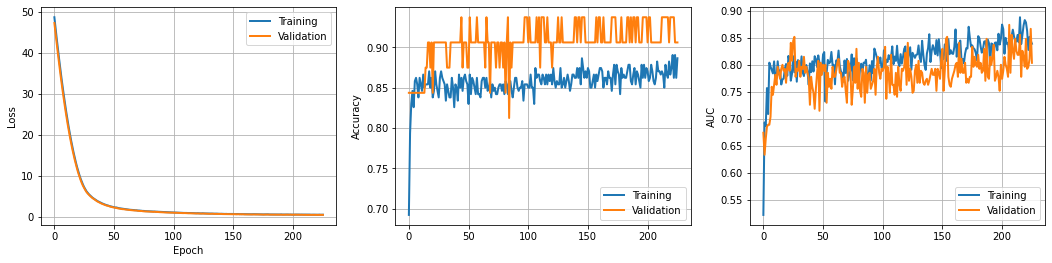

In [34]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(DNN.history.history['loss'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(DNN.history.history['accuracy'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(DNN.history.history['auc'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_auc'], label='Validation', linewidth=2)
plt.legend()
plt.ylabel('AUC')
plt.grid(True)

plt.show()

* Load best model

In [35]:
model = load_model("model_v1.h5")

* Testing results

In [36]:
test_loss = model.evaluate(x=sp.X_test, y=sp.Y_test, verbose=True)

1/1 [==============================] - 0s 362ms/step - loss: 0.6023 - accuracy: 0.8387 - auc: 0.7827


## Packaging in a Docker container

In [50]:
%%writefile train_v1.py

# Necessary libraries

import pickle
import matplotlib.pyplot as plt
import datetime 
import numpy as np
import pandas as pd
from functools import reduce
from varclushi import VarClusHi
from google.cloud import aiplatform, bigquery, storage
from google.oauth2 import service_account
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.losses import BinaryCrossentropy 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from feature_engineering import window_time
from transform import scaler_split

# Variables model

# Data engineering
t0 = datetime.datetime(2021, 1, 1) # Initial day
vobs=60 # Observation window backward for each day
vdes=7 # Performance window forward for each day
step=15 # Numer of days grouped to get metrics in the observation window
incremental=0.1 # Porcentage of increment minimum of the price in the performance window 

# Scaler and Split
val=0.1 # Validation set size
test=0.1 # Test set size
r_s=220327 # Random state
scaler='MinMaxScaler' # Escalation method

# Model
lr = 0.0001 # learning rate
bs = 16 # batch size
e = 300 # epochs

# Bucket
BUCKET = 'crispy-bucket-2022'
coin = 'btc'
version = 'v1'

# Get data from Big Query

#client = bigquery.Client()
credentials = service_account.Credentials.from_service_account_file("/.auth/crispy-key-2022.json", scopes=["https://www.googleapis.com/auth/cloud-platform"])
client = bigquery.Client(credentials=credentials, project=credentials.project_id)
query_job = client.query(
"""
SELECT
    id
    ,symbol
    ,name
    ,date
    ,market_data.current_price as current_price
    ,market_data.market_cap as market_cap
    ,market_data.total_volume as total_volume  
FROM
    `crispy-computing-machine.crispy_dwh.crypto_btc`
""")
df = query_job.result().to_dataframe()
df["date"]=pd.to_datetime(df["date"])
df=df[df["date"]>=t0]
df.sort_values(by=["date"],ascending=True,inplace=True)
df.reset_index(drop=True,inplace=True)
df.reset_index(drop=False,inplace=True)
df.rename(columns={"index":"t"},inplace=True)

# Feature Engineering 

window=window_time(vobs=vobs,vdes=vdes,step=step,incremental=incremental)
window.anclas(df['t'])
X=window.eng_X(df,['symbol','ancla'])
Y=window.eng_Y(df)

client = storage.Client()
gcs_bucket = client.get_bucket(BUCKET)

blob = gcs_bucket.blob(f'models/{coin}/{version}/X_{version}.pkl')
with blob.open(mode = 'wb') as file:
    pickle.dump(X,file)
    
blob = gcs_bucket.blob(f'models/{coin}/{version}/Y_{version}.pkl')
with blob.open(mode = 'wb') as file:
    pickle.dump(Y,file)

# Features selection

um=['symbol','ancla']
varc = sorted(X.filter(like='x_').columns)
vart = ['tgt']

# Outliers

for v,li,ls in X[varc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X[f'ex_{v}'] = ((X[v]<li)|(X[v]>ls)).astype(int)   
X['ex_'] = X.filter(like= 'ex_').max(axis=1)
X = X.loc[X['ex_']==0].reset_index(drop=True)
X.drop(X.filter(like='ex_').columns,axis=1,inplace=True)

# Multicollinearity

vc = VarClusHi(df=X,feat_list=varc)
vc.varclus()
rs = vc.rsquare
rs = rs.sort_values(by=['Cluster','RS_Ratio']).reset_index(drop=True)
rs['id'] = rs.groupby('Cluster').cumcount()+1
best = rs.loc[rs['id']==1]['Variable'].tolist()

blob = gcs_bucket.blob(f'models/{coin}/{version}/best_{version}.pkl')
with blob.open(mode = 'wb') as file:
    pickle.dump(best,file)

# Scaler and Split

tad = X[um+best].merge(Y,on=um,how='left')
sp=scaler_split(df=tad,X=best,Y=vart)
sp.split(val=val,test=test,rs=r_s)
sc = sp.scaler(scaler)

blob = gcs_bucket.blob(f'models/{coin}/{version}/scaler_{version}.pkl')
with blob.open(mode = 'wb') as file:
    pickle.dump(sc,file)
    
# Build model

checkpoints = ModelCheckpoint("model.h5",monitor='val_loss',verbose=10,save_best_only=True,
                              save_weights_only=False,mode="min",save_freq='epoch')
early_stop = EarlyStopping(monitor='val_loss', patience=10)

DNN = Sequential()
DNN.add(InputLayer(input_shape=sp.X_train.shape[1]))
DNN.add(Dense(2048, activation='relu'))
DNN.add(Dropout(rate=0.2))
DNN.add(Dense(1024, activation='relu',kernel_regularizer = l1_l2(0.001, 0.001)))
DNN.add(Dropout(rate=0.2))
DNN.add(Dense(256, activation='relu'))
DNN.add(BatchNormalization())
DNN.add(Dense(64, activation='relu'))
DNN.add(Dense(16, activation='relu',kernel_regularizer = l1_l2(0.01, 0.01)))
DNN.add(Dense(units=sp.Y_train.shape[1], activation='sigmoid'))
DNN.compile(optimizer=Adam(lr), loss= BinaryCrossentropy(),metrics=['accuracy','AUC'])
DNN.fit(x=sp.X_train, y=sp.Y_train, batch_size=bs, epochs=e, validation_data=(sp.X_val, sp.Y_val),callbacks=[checkpoints,early_stop])
model = load_model("model.h5")
model.save('gs://' + BUCKET + f'/models/{coin}/{version}/model_{version}')

Overwriting train_v1.py


* Save in project bucket

In [51]:
!gsutil cp train_v1.py gs://crispy-bucket-2022/models/utils/train_v1.py
!gsutil cp gs://crispy-bucket-2022/models/utils/train_v1.py train_v1.py

Copying file://train_v1.py [Content-Type=text/x-python]...
/ [1 files][  4.9 KiB/  4.9 KiB]                                                
Operation completed over 1 objects/4.9 KiB.                                      
Copying gs://crispy-bucket-2022/models/utils/train_v1.py...
/ [1 files][  4.9 KiB/  4.9 KiB]                                                
Operation completed over 1 objects/4.9 KiB.                                      


* Testing train_v1 script

In [39]:
! python -m train_v1

2022-04-30 23:38:47.265513: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
Epoch 1/300
16/16 [==============================] - ETA: 0s - loss: 48.8244 - accuracy: 0.6032 - auc: 0.5163
Epoch 1: val_loss improved from inf to 47.31404, saving model to model.h5
16/16 [==============================] - 3s 103ms/step - loss: 48.8244 - accuracy: 0.6032 - auc: 0.5163 - val_loss: 47.3140 - val_accuracy: 0.8438 - val_auc: 0.8111
Epoch 2/300
16/16 [==============================] - ETA: 0s - loss: 46.0060 - accuracy: 0.7368 - auc: 0.6279
Epoch 2: val_loss improved from 47.31404 to 44.57883, saving model to model.h5
16/16 [==============================] - 1s 79ms/step - loss: 46.0060 - accuracy: 0.7368 - auc: 0.6279 - val_loss: 44.5788 - val_accuracy: 0.8438 - val_auc: 0.8000
Epoch 3/300
16/16 [==============================] - ETA: 0s - loss: 43.2539 - accuracy: 0.8057

* Create dockerfile

In [52]:
%%writefile Dockerfile

FROM gcr.io/deeplearning-platform-release/tf2-cpu.2-3

RUN pip install varclushi

WORKDIR /

RUN mkdir /.auth
COPY crispy-key-2022.json /.auth/crispy-key-2022.json
COPY feature_engineering.py /feature_engineering.py
COPY transform.py /transform.py
COPY train_v1.py /train_v1.py

CMD export GOOGLE_APPLICATION_CREDENTIALS="/.auth/crispy-key-2022.json"
CMD gcloud auth activate-service-account 421888395673-compute@developer.gserviceaccount.com --key-file=/.auth/crispy-key-2022.json --project=crispy-computing-machine
CMD gcloud config set account 421888395673-compute@developer.gserviceaccount.com
CMD gcloud config set project crispy-computing-machine

ENTRYPOINT ["python", "-m", "train_v1"]

Overwriting Dockerfile


* Save in project bucket

In [53]:
!gsutil cp Dockerfile gs://crispy-bucket-2022/models/utils/Dockerfile
!gsutil cp gs://crispy-bucket-2022/models/utils/Dockerfile Dockerfile

Copying file://Dockerfile [Content-Type=application/octet-stream]...
/ [1 files][  695.0 B/  695.0 B]                                                
Operation completed over 1 objects/695.0 B.                                      
Copying gs://crispy-bucket-2022/models/utils/Dockerfile...
/ [1 files][  695.0 B/  695.0 B]                                                
Operation completed over 1 objects/695.0 B.                                      


* Create docker container in GCP

In [54]:
!gcloud builds submit --tag gcr.io/crispy-computing-machine/model:v1 .

Creating temporary tarball archive of 38 file(s) totalling 56.2 MiB before compression.
Uploading tarball of [.] to [gs://crispy-computing-machine_cloudbuild/source/1651364834.373894-f3bd6a5452fd4058bfb5b4f0c17e9fbf.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/crispy-computing-machine/locations/global/builds/c1772530-a764-44f1-a31d-5ff4db3ee70d].
Logs are available at [https://console.cloud.google.com/cloud-build/builds/c1772530-a764-44f1-a31d-5ff4db3ee70d?project=421888395673].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "c1772530-a764-44f1-a31d-5ff4db3ee70d"

FETCHSOURCE
Fetching storage object: gs://crispy-computing-machine_cloudbuild/source/1651364834.373894-f3bd6a5452fd4058bfb5b4f0c17e9fbf.tgz#1651364842550375
Copying gs://crispy-computing-machine_cloudbuild/source/1651364834.373894-f3bd6a5452fd4058bfb5b4f0c17e9fbf.tgz#1651364842550375...
- [1 files][ 48.0 MiB/ 48.0 MiB]                                             

## Job for training our model

* Define a function for job

In [60]:
%%writefile jobs_train.py
from google.cloud import aiplatform
import time

def create_custom_job(
    date: str,
    project: str,
    display_name: str,
    container_image_uri: str,
    location: str = "us-central1",
    api_endpoint: str = "us-central1-aiplatform.googleapis.com"
):
    """
    Creates custom training job
    
    Parameters
    ----------  
    date : str
        Format : '%Y-%m-%d'
    project : str
        Project name
    display_name : str
        Name of custom training job
    container_image_uri: str
        image_uri
    location : str
        Default: 'us-central1'
    api_endpoint : str
        api_endpoint option for Job Service Client
        
    Returns
    -------
    str
        Returns response of client.create_custom_job and executes the job in Vertex AI 
    """
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.JobServiceClient(client_options=client_options)
    custom_job = {
        "display_name": display_name + "_" + date,
        "job_spec": {
            "worker_pool_specs": [
                {
                    "machine_spec": {
                        "machine_type": "n1-standard-4",
                        "accelerator_type": aiplatform.gapic.AcceleratorType.NVIDIA_TESLA_K80,
                        "accelerator_count": 1,
                    },
                    "replica_count": 1,
                    "container_spec": {
                        "image_uri": container_image_uri,
                        "command": [],
                        "args": [],
                    },
                }
            ]
        },
    }
    parent = f"projects/{project}/locations/{location}"
    response = client.create_custom_job(parent=parent, custom_job=custom_job)
    time.sleep(600) 
    print("response:", response)

Overwriting job_train.py


* Save in project bucket

In [81]:
!gsutil cp jobs_train.py gs://crispy-bucket-2022/models/utils/jobs_train.py
!gsutil cp gs://crispy-bucket-2022/models/utils/jobs_train.py jobs_train.py

E0501 01:22:54.399106718    3362 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying file://jobs_train.py [Content-Type=text/x-python]...
/ [1 files][  2.0 KiB/  2.0 KiB]                                                
Operation completed over 1 objects/2.0 KiB.                                      


E0501 01:22:56.084098921    3362 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying gs://crispy-bucket-2022/models/utils/jobs_train.py...
/ [1 files][  2.0 KiB/  2.0 KiB]                                                
Operation completed over 1 objects/2.0 KiB.                                      


* Execute the training job function

In [62]:
from jobs_train import create_custom_job

custom_job=create_custom_job(
    date = '2022-04-30',
    project="crispy-computing-machine",
    display_name="model_v1",
    container_image_uri="gcr.io/crispy-computing-machine/model@sha256:42c5b70a88ef4ae57bab8d5d6ba9e0afe7a1b5ae5a5e0c8f1b3b4688ab6cb9dd",
    location="us-central1",
    api_endpoint="us-central1-aiplatform.googleapis.com"
)


response: name: "projects/421888395673/locations/us-central1/customJobs/2534311080105082880"
display_name: "model_v1"
job_spec {
  worker_pool_specs {
    machine_spec {
      machine_type: "n1-standard-4"
      accelerator_type: NVIDIA_TESLA_K80
      accelerator_count: 1
    }
    replica_count: 1
    disk_spec {
      boot_disk_type: "pd-ssd"
      boot_disk_size_gb: 100
    }
    container_spec {
      image_uri: "gcr.io/crispy-computing-machine/model@sha256:42c5b70a88ef4ae57bab8d5d6ba9e0afe7a1b5ae5a5e0c8f1b3b4688ab6cb9dd"
    }
  }
}
state: JOB_STATE_PENDING
create_time {
  seconds: 1651366081
  nanos: 857469000
}
update_time {
  seconds: 1651366081
  nanos: 857469000
}



## Endpoint Deployment

In [90]:
%%writefile endpoint.py
from google.cloud import aiplatform

def model_endpoint(date,name,model,image,machine='n1-standard-4'):
    """
    Creates a model through Vertex AI and deploys it into an endpoint from Vertex AI
    
    Parameters
    ----------   
    date : str
        Format : '%Y-%m-%d'
    name : str
        Name of the model in Vertex AI
    model : str
        Bucket path of model to deploy
    image: str
        Container image uri
    machine : str
        Default: 'n1-standard-4'
        
    Returns
    -------
    str
        Executes a model and an endpoint through Vertex AI 
    """
    model = aiplatform.Model.upload(
        display_name=name + "_" + date,
        artifact_uri=model,
        serving_container_image_uri=image)

    endpoint = model.deploy(
        machine_type=machine)

Writing endpoint.py


* Save in project bucket

In [91]:
!gsutil cp endpoint.py gs://crispy-bucket-2022/models/utils/endpoint.py
!gsutil cp gs://crispy-bucket-2022/models/utils/endpoint.py endpoint.py

Copying file://endpoint.py [Content-Type=text/x-python]...
/ [1 files][  742.0 B/  742.0 B]                                                
Operation completed over 1 objects/742.0 B.                                      
Copying gs://crispy-bucket-2022/models/utils/endpoint.py...
/ [1 files][  742.0 B/  742.0 B]                                                
Operation completed over 1 objects/742.0 B.                                      


* Execute endpoint deployment

In [93]:
from endpoint import model_endpoint

model_endpoint(
date="2022-04-30",
name="model_v1",
model="gs://crispy-bucket-2022/models/btc/v1/model_v1/",
image="gcr.io/cloud-aiplatform/prediction/tf2-cpu.2-3:latest",
machine='n1-standard-4'
)

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/421888395673/locations/us-central1/models/290574534942130176/operations/4218582642670436352
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/421888395673/locations/us-central1/models/290574534942130176
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/421888395673/locations/us-central1/models/290574534942130176')
INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/421888395673/locations/us-central1/endpoints/5358834955826757632/operations/4254611439689400320
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/421888395673/locations/us-central1/endpoints/5358834955826757632
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session

## Making a prediction from an End-point

In [128]:
%%writefile predictions.py

import datetime 
import pickle
import pandas as pd
from feature_engineering import window_time
from transform import scaler_split
from google.cloud import bigquery,storage,aiplatform

def predictions(vobs,vdes,step,incremental,best,bucket,scaler,endpoint_n,day):
    
    """
    Predicts if price from a selected day will go up certain incremental rate over 
    the next x days
    
    Parameters
    ----------        
    vobs : int
        Observation window backward for the selected day
    vdes : int
        Performance window forward for the selected day
    step: int
        Number of days grouped to get metrics in the observation window
    incremental : float
        Porcentage of increment minimum of the price in the performance window
    best : str
        Path from bucket of the list object best features
    bucket : str
        Bucket name
    scaler : str
        Path from bucket of the object scaler for the features
    endpoint_n : str
        Endpoint name
    day : datetime
        Day for the prediction
        
    Returns
    -------
    str
        Prediction for the selected day 
    """

    client = bigquery.Client()
    query_job = client.query(
    """
    SELECT DISTINCT
        date
    FROM
        `crispy-computing-machine.crispy_dwh.crypto_btc`
    """)
    df = query_job.result().to_dataframe()
    if day.date() not in df["date"].values:
        print("The selected day is not yet available")
        return 0
    else:
        query_job = client.query(
        """
        SELECT
            id
            ,symbol
            ,name
            ,date
            ,market_data.current_price as current_price
            ,market_data.market_cap as market_cap
            ,market_data.total_volume as total_volume  
        FROM
            `crispy-computing-machine.crispy_dwh.crypto_btc`
        """)
        df = query_job.result().to_dataframe()
        df["date"]=pd.to_datetime(df["date"])
        df=df[df["date"]>=day - datetime.timedelta(days = vobs)]
        df=df[df["date"]<=day + datetime.timedelta(days = vdes)]
        df.sort_values(by=["date"],ascending=True,inplace=True)
        df.reset_index(drop=True,inplace=True)
        df.reset_index(drop=False,inplace=True)
        df.rename(columns={"index":"t"},inplace=True)

        window=window_time(vobs=vobs,vdes=vdes,step=step,incremental=incremental)
        window.anclas(df['t'])
        window.anclai=df["t"].max()-window.vdes
        window.anclaf=df["t"].max()-window.vdes
        X=window.eng_X(df,['symbol','ancla'])
        
        client = storage.Client()
        gcs_bucket = client.get_bucket(bucket)
        blob = gcs_bucket.blob(best)
        with blob.open(mode = 'rb') as file:
            best=pickle.load(file)
        X=X[best]
        
        cp=df[df["t"]==df["t"].max()-window.vdes]["current_price"].values[0]

        blob = gcs_bucket.blob(scaler)
        with blob.open(mode = 'rb') as file:
            sc = pickle.load(file)
        X=sc.transform(X)

        endpoint = aiplatform.Endpoint(
        endpoint_name=aiplatform.Endpoint.list(filter=f'display_name="{endpoint_n}"')[0].resource_name)
        response = endpoint.predict([list(X[0])])
        
        print(f"Probability of current price ({round(cp,2)}) will go up {round(incremental*100,2)}% over the next {vdes} days is: {round(response.predictions[0][0]*100,2)}%")
        
        return response

Writing predictions.py


* Save in project bucket

In [129]:
!gsutil cp predictions.py gs://crispy-bucket-2022/models/utils/predictions.py
!gsutil cp gs://crispy-bucket-2022/models/utils/predictions.py predictions.py

E0501 02:26:44.768364842    3362 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying file://predictions.py [Content-Type=text/x-python]...
/ [1 files][  3.3 KiB/  3.3 KiB]                                                
Operation completed over 1 objects/3.3 KiB.                                      


E0501 02:26:46.633555617    3362 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying gs://crispy-bucket-2022/models/utils/predictions.py...
/ [1 files][  3.3 KiB/  3.3 KiB]                                                
Operation completed over 1 objects/3.3 KiB.                                      


* Make a prediction

In [135]:
from predictions import predictions

p=predictions(
    vobs=60,vdes=7,step=15,incremental=0.1,
    best='models/btc/v1/best_v1.pkl',bucket='crispy-bucket-2022',scaler='models/btc/v1/scaler_v1.pkl',
    endpoint_n='model_v1_endpoint',
    day=datetime.datetime(2022, 4, 24))

Probability of current price (40450.38) will go up 10.0% over the next 7 days is: 21.84%


## Features and predictions

In [101]:
%%writefile predict_fp.py

import pickle
import pandas as pd
import numpy as np
from google.cloud import storage,aiplatform

def predictions(bucket,X,Y,best,scaler,endpoint_name,features,predictions):
    
    """
    Creates features and predictions csv files
    
    Parameters
    ----------        
    bucket : str
        Bucket name
    X : str
        Path from bucket of the object X
    Y : str
        Path from bucket of the object Y
    best : str
        Path from bucket of the list object best features
    scaler : str
        Path from bucket of the object scaler for the features
    endpoint_name : str
        Endpoint name
    features : str
        Path from bucket of the file features table
    predictions : str
        Path from bucket of the file predictions table
        
    Returns
    -------
    str
        Predictions 
    """

    client = storage.Client()
    gcs_bucket = client.get_bucket(bucket)

    blob = gcs_bucket.blob(X)
    with blob.open(mode = 'rb') as file:
        X = pickle.load(file)

    blob = gcs_bucket.blob(Y)
    with blob.open(mode = 'rb') as file:
        Y = pickle.load(file)

    blob = gcs_bucket.blob(best)
    with blob.open(mode = 'rb') as file:
        best=pickle.load(file)

    blob = gcs_bucket.blob(scaler)
    with blob.open(mode = 'rb') as file:
        scaler = pickle.load(file)

    df=X.merge(Y,how="outer",on=["symbol","ancla"])

    gcs_bucket.blob(features).upload_from_string(df.to_csv(index=False), 'csv')

    Xs=scaler.transform(X[best])

    endpoint = aiplatform.Endpoint(
        endpoint_name=aiplatform.Endpoint.list(filter=f'display_name="{endpoint_name}"')[0].resource_name
    )

    response = endpoint.predict([list(x) for x in Xs])

    Y_gorro=np.array(response[0])

    df["predict"]=Y_gorro

    df=df[["symbol","ancla","tgt","predict"]+best]

    gcs_bucket.blob(predictions).upload_from_string(df.to_csv(index=False), 'csv')

    return response

Writing predict_fp.py


In [103]:
from predict_fp import predictions

p=predictions(
bucket="crispy-bucket-2022",
X="models/btc/v1/X_v1.pkl",
Y="models/btc/v1/Y_v1.pkl",
best="models/btc/v1/best_v1.pkl",
scaler="models/btc/v1/scaler_v1.pkl",
endpoint_name="model_v1_endpoint",
features="models/btc/v1/features_v1.csv",
predictions="models/btc/v1/predictions_v1.csv"
)
